In [129]:
import os
import sys
from pathlib import Path
# Make sure all code is in the PATH.
sys.path.append("../src/")

In [130]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LogNorm

In [131]:
# Plot styling.
plt.style.use(["seaborn-white", "seaborn-paper"])
plt.rc("font", family="sans-serif")
sns.set_palette(["#9e0059", "#6da7de", "#ee266d", "#dee000", "#eb861e"])
sns.set_context("paper")

# ensure directory
Path("results/img/").mkdir(parents=True, exist_ok=True)

## Finished setup, start plotting

In [132]:
# filename = "results/BILELIB19_all_sqrt_False_2000000pairs_6min_signals_True_requirestruc_4i0-200deltamz_0mods.parquet"
# filename = "results/20220418_ALL_GNPS_NO_PROPOGATED_all_sqrt_False_5000000pairs_6min_signals_True_requirestruc_4i0-200deltamz_0mods.parquet"
# filename = "results/20220418_ALL_GNPS_NO_PROPOGATED_hexose_sqrt_False_500000pairs_6min_signals_True_requirestruc_162i05282400000002specific_delta_0mods.parquet"
filename = "results/BILELIB19_aminos_sqrt_False_200000pairs_6min_signals_True_requirestruc_4i0-200deltamz_5mods.parquet"
# filename = "results/BILELIB19_oxy_sqrt_False_500000pairs_6min_signals_True_requirestruc_15i9949specific_delta_0mods.parquet"

# use filename to identify exported files
analysis_id = Path(filename).stem

similarities = pd.read_parquet(filename)
similarities.head(5)

,id1,id2,delta_mz,tanimoto,cos_score,cos_matched_intensity,cos_max_contribution,cos_n_greq_2p,cos_matches,mod_score,mod_matched_intensity,mod_max_contribution,mod_n_greq_2p,mod_matches,nl_score,nl_matched_intensity,nl_max_contribution,nl_n_greq_2p,nl_matches
0,CCMSLIB00005465932,CCMSLIB00006584901,71.052,0.4146,0.113499,0.774745,0.047042,2,449,0.471910,0.977333,0.291967,5,557,0.362697,0.786954,0.291967,3,355
1,CCMSLIB00006584929,CCMSLIB00006582066,71.052,0.4146,0.134928,0.844497,0.050647,2,70,0.514076,0.998716,0.279896,5,84,0.382764,0.792279,0.279896,3,36
2,CCMSLIB00005464988,CCMSLIB00006584782,107.022,0.2202,0.085787,0.743008,0.012525,0,346,0.091285,0.780971,0.012525,0,408,0.005596,0.102964,0.004922,0,128
3,CCMSLIB00005465734,CCMSLIB00006583477,71.037,0.5090,0.349480,0.909276,0.106176,2,200,0.480591,0.934568,0.199015,2,210,0.269219,0.814162,0.199015,1,135
4,CCMSLIB00005465792,CCMSLIB00006584286,57.003,0.4193,0.127422,0.787538,0.017072,0,364,0.157200,0.916237,0.017255,0,420,0.030529,0.476978,0.017255,0,219


In [133]:
# remove rows where all scores are 0
similarities = similarities[(similarities["cos_score"]>0) & (similarities["mod_score"]>0) & (similarities["nl_score"]>0)]
len(similarities)

5911

In [134]:
total = len(similarities)
stats = {
    'total': total,
    'cos higher': len(similarities[similarities["cos_score"]>similarities["nl_score"]])/ total,
    'nl higher': len(similarities[similarities["cos_score"]<similarities["nl_score"]])/ total
}
print(stats)

{'total': 5911, 'cos higher': 0.38081542886144476, 'nl higher': 0.6191845711385552}


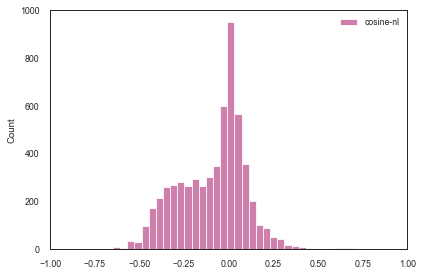

In [135]:
df = pd.DataFrame()
df['cosine-nl'] = similarities['cos_score'] - similarities['nl_score']
ax = sns.histplot(data=df, binwidth=0.04)
ax.set_xlim((-1,1))

plt.savefig("results/img/diff_{}.png".format(analysis_id), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

In [136]:
def group_tanimoto(tanimoto):
    if tanimoto >= 0.8: return "≥0.8"
    if tanimoto >= 0.6: return "≥0.6"
    if tanimoto >= 0.4: return "≥0.4"
    if tanimoto >= 0.0: return "≥0"
    else: return 'unclassified'

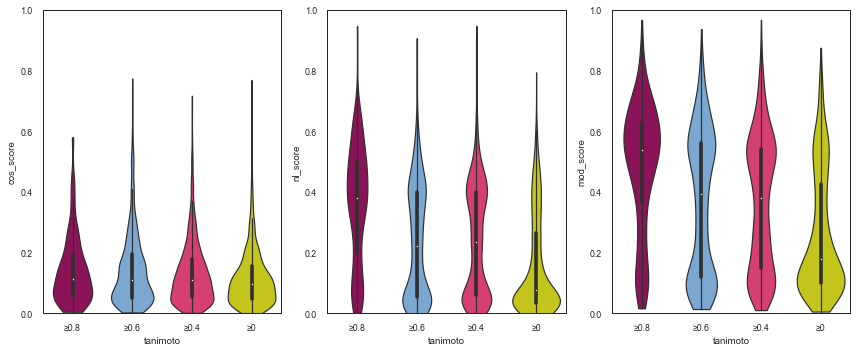

In [137]:
# tanimoto score
hueorder = ["≥0.8","≥0.6","≥0.4","≥0"]
similarities["tanimoto_cat"] = similarities["tanimoto"].apply(group_tanimoto)

score = ["cos_score","nl_score","mod_score"]
fig, axes = plt.subplots(1, 3, figsize=(12, 5))

for i, ax in enumerate(axes.flatten()):
    sns.violinplot(y=score[i],
                   x="tanimoto_cat",
                   data=similarities,
                   cut=0,
                   ax=ax,
                   order=hueorder
                   )
    ax.set_xlabel("tanimoto")
    ax.set_ylim((0,1))

    # sns.stripplot(y=score[i],
    #               x="tanimoto_cat",
    #               data=similarities,
    #               ax=ax,
    #               order=hueorder,
    #               color="black", edgecolor="gray", size=2)


plt.tight_layout()

plt.savefig("results/img/tanimoto_violin_{}.png".format(analysis_id), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

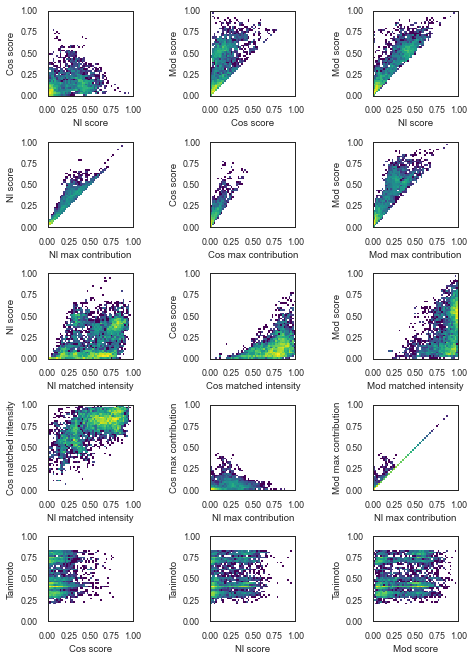

In [138]:
plots = [
        ["nl_score", "cos_score"],
        ["cos_score", "mod_score"],
        ["nl_score", "mod_score"],
        ["nl_max_contribution", "nl_score"],
        ["cos_max_contribution", "cos_score"],
        ["mod_max_contribution", "mod_score"],
        ["nl_matched_intensity", "nl_score"],
        ["cos_matched_intensity", "cos_score"],
        ["mod_matched_intensity", "mod_score"],
        ["nl_matched_intensity", "cos_matched_intensity"],
        ["nl_max_contribution", "cos_max_contribution"],
        ["nl_max_contribution", "mod_max_contribution"],
        ["cos_score", "tanimoto"],
        ["nl_score", "tanimoto"],
        ["mod_score", "tanimoto"],
    ]

fig, axes = plt.subplots(5, 3, figsize=(7, 15 / 1.618))

bins = 50
tick_locators = mticker.FixedLocator(np.arange(0, bins + 1, bins / 4))
tick_labels = np.asarray([f"{a:.2f}" for a in np.arange(0, 1.01, 0.25)])

for i, ax in enumerate(axes.flatten()):
    if i >= len(plots):
        break

    (xlabel, ylabel) = plots[i]
    hist, _, _ = np.histogram2d(
        similarities[xlabel],
        similarities[ylabel],
        bins=bins,
        range=[[0, 1], [0, 1]],
    )
    heatmap = sns.heatmap(
        np.rot90(hist),
        cmap="viridis",
        cbar=False,
        square=True,
        xticklabels=False,
        yticklabels=False,
        ax=ax,
        norm=LogNorm(),
    )
    ax.yaxis.set_major_locator(tick_locators)
    ax.set_yticklabels(tick_labels[::-1])
    ax.xaxis.set_major_locator(tick_locators)
    ax.set_xticklabels(tick_labels)
    for _, spine in heatmap.spines.items():
        spine.set_visible(True)
    ax.set_xlabel(xlabel.replace("_", " ").capitalize())
    ax.set_ylabel(ylabel.replace("_", " ").capitalize())


plt.tight_layout()

plt.savefig("results/img/score_contributions_{}.png".format(analysis_id), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

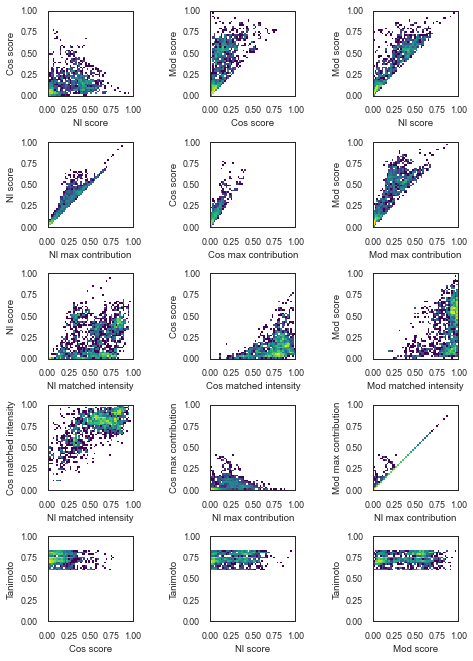

In [139]:
plots = [
    ["nl_score", "cos_score"],
    ["cos_score", "mod_score"],
    ["nl_score", "mod_score"],
    ["nl_max_contribution", "nl_score"],
    ["cos_max_contribution", "cos_score"],
    ["mod_max_contribution", "mod_score"],
    ["nl_matched_intensity", "nl_score"],
    ["cos_matched_intensity", "cos_score"],
    ["mod_matched_intensity", "mod_score"],
    ["nl_matched_intensity", "cos_matched_intensity"],
    ["nl_max_contribution", "cos_max_contribution"],
    ["nl_max_contribution", "mod_max_contribution"],
    ["cos_score", "tanimoto"],
    ["nl_score", "tanimoto"],
    ["mod_score", "tanimoto"],
]

filtered_df = similarities[similarities["tanimoto"]>0.6]

fig, axes = plt.subplots(5, 3, figsize=(7, 15 / 1.618))

bins = 50
tick_locators = mticker.FixedLocator(np.arange(0, bins + 1, bins / 4))
tick_labels = np.asarray([f"{a:.2f}" for a in np.arange(0, 1.01, 0.25)])

for i, ax in enumerate(axes.flatten()):
    if i >= len(plots):
        break

    (xlabel, ylabel) = plots[i]
    hist, _, _ = np.histogram2d(
        filtered_df[xlabel],
        filtered_df[ylabel],
        bins=bins,
        range=[[0, 1], [0, 1]],
    )
    heatmap = sns.heatmap(
        np.rot90(hist),
        cmap="viridis",
        cbar=False,
        square=True,
        xticklabels=False,
        yticklabels=False,
        ax=ax,
        norm=LogNorm(),
    )
    ax.yaxis.set_major_locator(tick_locators)
    ax.set_yticklabels(tick_labels[::-1])
    ax.xaxis.set_major_locator(tick_locators)
    ax.set_xticklabels(tick_labels)
    for _, spine in heatmap.spines.items():
        spine.set_visible(True)
    ax.set_xlabel(xlabel.replace("_", " ").capitalize())
    ax.set_ylabel(ylabel.replace("_", " ").capitalize())


plt.tight_layout()

plt.savefig("results/img/tanimoto_filter_{}.png".format(analysis_id), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

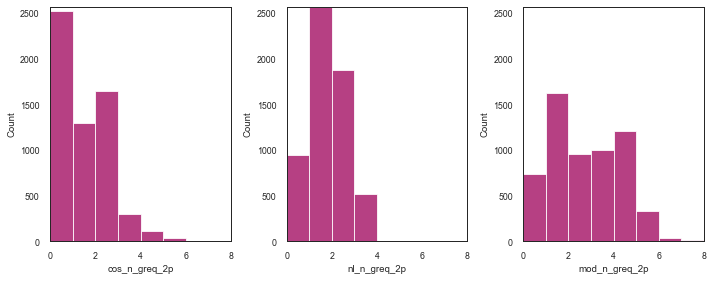

In [140]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

xlabels = ["cos_n_greq_2p","nl_n_greq_2p","mod_n_greq_2p"]
max_x = similarities[["cos_n_greq_2p","nl_n_greq_2p","mod_n_greq_2p"]].max().max()
max_y = max(similarities[xlabel].value_counts()[0] for xlabel in xlabels) * 1.02

for i, ax in enumerate(axes.flatten()):
    xlabel = xlabels[i]

    hist = sns.histplot(data=similarities, x=xlabel, binwidth=1, ax= ax)
    # for _, spine in hist.spines.items():
    #     spine.set_visible(True)
    # ax.set_xlabel(xlabel.replace("_", " ").capitalize())
    # ax.set_ylabel(ylabel.replace("_", " ").capitalize())

    ax.set_xlim((0,max_x))
    ax.set_ylim((0,max_y))

plt.tight_layout()

plt.savefig("results/img/greater_2p_signals_{}.png".format(analysis_id), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

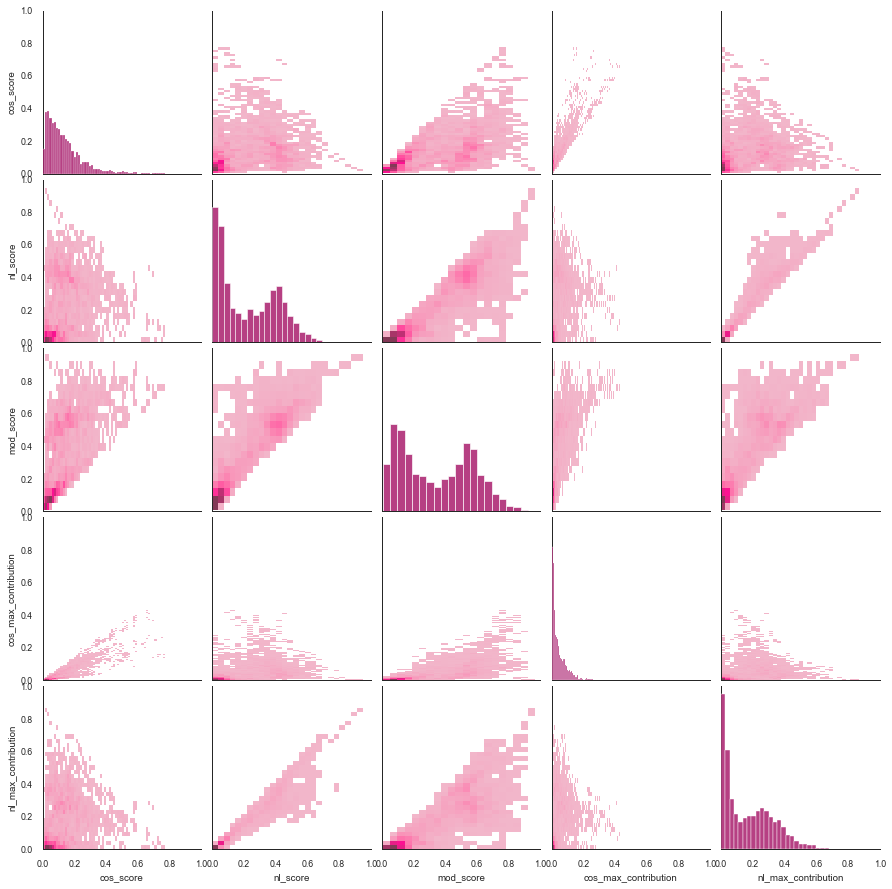

In [141]:
g = sns.pairplot(similarities, kind="hist",
             vars=["cos_score", "nl_score", "mod_score", "cos_max_contribution", "nl_max_contribution"])
for axes in g.axes:
    for a in axes:
        a.set_xlim((0,1))
        a.set_ylim((0,1))

plt.savefig("results/img/pair_{}.png".format(analysis_id), dpi=300, bbox_inches="tight")
plt.show()
plt.close()